# Исследование объявлений о продаже квартир

В качестве данных для исследования выступают данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо определить рыночную стоимость объектов недвижимости и  установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования**

1. Определить рыночную стоимость объектов недвижимости
2. Создать автоматизированную систему, которая отследит аномалии и мошенническую деятельность
3. Выявить факторы, влияющие на ценообразование стоимости квартир


Для достижения целей исследования необходимо выполнить следующие этапы:
1. Обзор данных
2. Предобработка данных
3. Расчеты и добавление их результатов в таблицу
4. Исследовательский анализ данных
6. Общий вывод

### 1. Обзор данных

In [1]:
import pandas as pd   # импортируем библиотеки
import matplotlib.pyplot as plt 

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')  # импортируем базу недвижимости, в качестве разделителя - табуляция

print(data.info())  # запрашиваем общую информацию о базе

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [2]:
print(data.head())  # смотрим первые 5 строчек

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

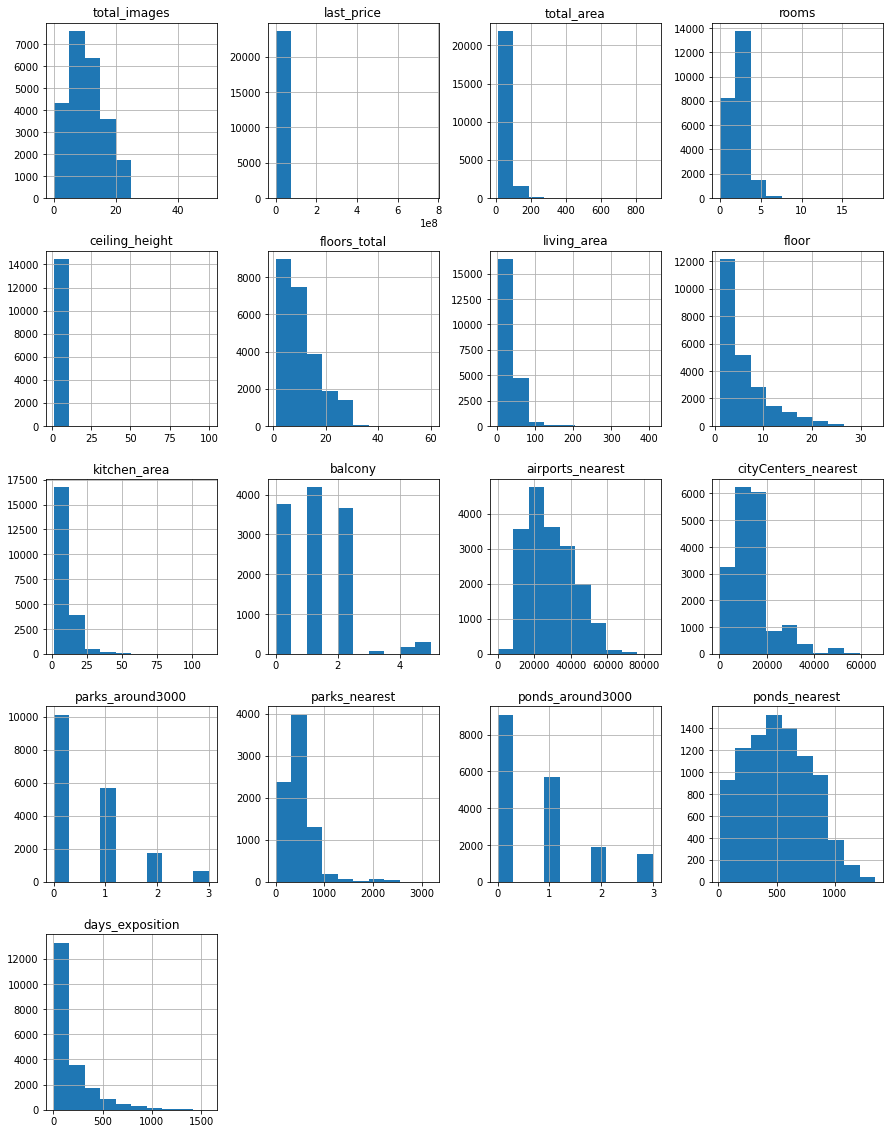

In [3]:
data.hist(figsize=(15, 20))  # строим гистограммы для столбцов с числовыми значениями
plt.show()

Обзор данных показал наличие пропущенных значений в базе, несоответствие типов данных 

### 2. Предобработка данных

#### 2.1. Обработка пропущенных значений

In [4]:
data.isna().sum()  # смотрим сколько всего пропусков в базе

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Анализ базы показал что в 14 столбцах из 22 наблюдаются пропуски. 
Часть из них относится к техническим характеристикам квартиры/дома (ceiling_height, kitchen_area,living_area, is_apartment, balcony, floors_total), часть - к характеристикам района/географической удаленности квартиры/дома (airports_nearest, cityCenters_nearest, parks_around, parks_nearest, ponds_around, ponds_nearest, locality_name).
Встречаются также и 3181 пропуск в колонке days_exposition - сколько дней было размещено объявление. 
Отсутствие данных в этом столбце означает что на момент выгрузки архива оно еще выставлялось - эти данные не меняем.

Заполняем пропущенные значения там, где это возможно, особое внимание уделяем первой группе характеристик, т.к. они являются ключевыми в базе недвижимости.

Заполняем поля 'balcony', 'is_apartment' - пропущенные значения тут принимаем за "0" в балконах (нет информации - нет балкона), в апартаментах - за значение "False' - не является апартаментом.
Переходим к этажности объектов.

In [5]:
data.head()
data['balcony'] = data['balcony'].fillna(0)  # меняем пропущенные значения в поле "балконы" на 0
data['is_apartment'] = data['is_apartment'].fillna('False') # меняем пропущенные значения в поле "апртаменты" на False 
data.query('floors_total.isna()').head()  # смотрим примеры записей с пропущенным общим количеством этажей

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,False,...,12.00,0.0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,False,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,False,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,False,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,False,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0


Принимаем тяжелое решение удалить строки с пустыми данными в floors_total. Эту информацию мы не можем ни рассчитать, ни вывести среднее, только угадать. 
Числовые данные из этого столбца при этом будут необходимы в дальнейшем для расчета типа этажа. Это 86 записей - менее 0,5% от общей базы.

In [6]:
data = data.dropna(subset=['floors_total'])  # удаляем строки с пустыми значениям в floors_total
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9118
floors_total                0
living_area              1870
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2231
balcony                     0
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

В данных о жилой площади и площади кухни примерно в 8% данных информация отсутствует. Попробуем ее рассчитать - в большинстве случаев она является типовой и прямо коррелирует с общей площадью квартиры. Рассчитаем как соотносятся жилая площадь/площадь кухни и общая жилплощадь. 

In [7]:
print (
        'Гостиная относительно общей жилой площади, медиана и среднее:',
       ((data['living_area']/ data['total_area']).median()),
       ((data['living_area']/ data['total_area']).mean())
) # рассчитываем пропорцию гостиной относительно общей жилой площади
print('Кухня относительно общей жилой площади, медиана и среднее', ((data['kitchen_area']/data['total_area']).median()), ((data['kitchen_area']/data['total_area']).mean())) # рассчитываем пропорцию кухни относительно общей жилой площади
data.head() 

Гостиная относительно общей жилой площади, медиана и среднее: 0.5681818181818182 0.5649479605594985
Кухня относительно общей жилой площади, медиана и среднее 0.1723476871686878 0.18732402442071253


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Т.к. медиана и среднее значения практически не отличаются, то принимаем решение заполнять пропущенные значения средней пропорцией.

In [8]:
data['living_area'] = data['living_area'].fillna(data['total_area'] * ((data['living_area']/ data['total_area']).mean()))  # заполняем пропущенные значения площади гостиной пересчетом коэффициента доли гостиной на общую площади
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * ((data['kitchen_area']/data['total_area']).mean())) # аналогично делаем с кухней
data.head()  # проверяем что данные благополучно заполнились

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,...,25.00000,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.600000,1,False,...,11.00000,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.300000,4,False,...,8.30000,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,89.826726,9,False,...,29.78452,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,...,41.00000,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Смотрим какие пропуски еще мы можем заполнить. Принимаем решение удалить еще 48 записей (менее 0,2% от общей базы) - данные без указанного населенного пункта (locality_name), т.к. это критическая информация для анализа и использования базы.

In [9]:
data = data.dropna(subset=['locality_name'])  # удаляем строки с пустыми значениям в locality_name

Заполняем пропущенные значения в столбце 'ceiling_height' медианным значением потолков в базе. Выбираем медиану, т.к. в базе есть выбросы, которые влияют на среднее значение.

In [10]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())   # заполняем пропущенные значения высоты потолков медианным значением
data.isna().sum()  # смотрим какая ситуация с пропусками теперь в базе

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

С пропусками в базе работа закончена. Они остались в "географических" полях - расстояние до объектов, наличие инфраструкты. Для заполнения этих полей необходим точный адрес объекта. Кроме того остались пропуски в поле days_exposition  - это означает объявления еще не закрыты.

####  2.2 Изменение типа данных

In [11]:
data.info()  # смотрим на типы данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Решаем поменять тип данных на int в следующих колонках:  last price, floors_total, balcony, parks_around3000  и ponds_around3000. В последних двух есть значения NaN, поэтому их сначала надо будет изменить на 0.

Тип данных в first_day_exposition меняем на временной

Тип данных is_apartment из object меняем на bool

In [12]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])  # переводим object в дату и время
data['floors_total'] =  data['floors_total'].astype('int')  # переводим данные в int
data['balcony'] =  data['balcony'].astype('int')
data['last_price'] =data['last_price'].astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(0)   # заполняем пропуски нулями
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)  # заполняем пропуски нулями
data['parks_around3000'] =  data['parks_around3000'].astype('int')  # и благополучно переводим в int
data['ponds_around3000'] =  data['ponds_around3000'].astype('int')
data['is_apartment'] =  data['is_apartment'].astype('bool')  # переводим в bool
data.info()  #смотрим на результат
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,True,...,25.00000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,True,...,11.00000,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,True,...,8.30000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.826726,9,True,...,29.78452,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,...,41.00000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


Данные были изменены для удобства дальнейшей работы с базой. В дальнейшем мы сможем анализировать и сопоставлять данные, строить графики и искать корреляции. Кроме того так данные просто удобнее и легче читать.

#### 2.3 Проверка на наличие явных дубликатов

In [2]:
data.duplicated().sum()

NameError: name 'data' is not defined

Дубликаты отсутствуют

#### 2.4 Изучение уникальных значений в столбце с названиями и устранение неявных дубликатов.

In [13]:
data['locality_name'].unique()  # смотрим уникальные названия населенных пунктов

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Для устранения неявных дубликатов среди населенных пунктов принимаем решение удалить всю информацию относительно типа населенного пункта, т.к. отсутствуют стандартные формулировки. Создаем список нежелательных слов в названии blacklisted_words, запускаем по нему цикл и перезаписываем датафрейм с заменными на пустые скобки значениями. 

In [14]:
blacklisted_words = ['посёлок ', 'поселок ', 'городской посёлок ', 'деревня ', 'деревня ', 'коттеджный ', 'городской ', 'имени ', 'при железнодорожной станции ','станции ', 'посёлок городского типа ', 'городского типа ', 'поселок городского типа ', 'посёлок городского типа ', 'садовое товарищество ', 'село ', 'городской поселок ', 'садоводческое некоммерческое товарищество ', 'городской  ', 'коттеджный  ', 'посёлок при железнодорожной станции ','коттеджный поселок ', 'коттеджный посёлок ',' городского типа ']  # создаем список слов, которые хотим убрать
for word in blacklisted_words:  # запускаем цикл по списку с нежелательным словами 
    data['locality_name']= data['locality_name'].str.replace(word, '')  # удаляем заменой на пустые скобки, перезаписывая датафрейм
data['locality_name'].unique()  # смотрим новые уникальные значения

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

#### 2.5 Редкие и выбивающиеся значения

Для поиска аномалий применим метод describe к датафрейму и посмотрим на минимальные, максимальные и средние значения в поисках явных ошибок или выбросов.

In [15]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,18041.000000,18064.000000,23565.000000,8030.000000,23565.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.724530,10.675875,34.561055,5.878124,10.565298,0.593677,28797.082701,14192.656056,0.468831,490.580448,0.589900,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,0.991026,6.594823,22.346086,4.871485,6.093122,0.960660,12632.499735,8613.348153,0.748403,341.572956,0.883966,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26757.000000,13096.500000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.700000,16.000000,42.100000,8.000000,12.000000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


После анализа базы на себя обратили внимания следующие значения:

Общая площадь квартир (total_area): минимальное значение 12, максимальное 900. При этом Согласно законодательству площадь жилого помещения (в том числе и студии) должна быть не меньше 19 квадратных метров. 

In [16]:
data.query('total_area < 19')['total_area'].count()  # смотрим сколько объектов с жил.площадью менее 19 м.

24

Меньше 19 м. могут быть апартаменты, проверим это.

In [17]:
data.query('(total_area < 20) and (is_apartment == True)')['total_area'].count()

23

Объекты с площадью менее 19 м. из базы удалим. По гистограмме видны выбросы объектов с большой площадью. Посмотрим на диаграмме размаха:

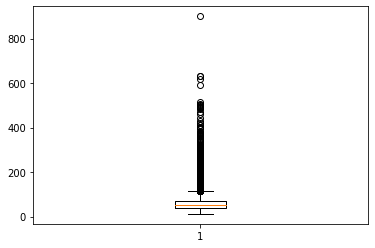

In [18]:
plt.boxplot(data['total_area'])
plt.show()

Межквартильный размах для  total_area наблюдается в диапазоне от 0 до 114 кв.м. Однако площадь свыше 100-120 метров не является необычной для жилой площади, особенно для современной постройки. Какое количество квартир превышает 250 м. общей площади? Квартиры площади более 250 метров не являются типовыми и принадлежат к более узкому сегменту недвижимости.

In [19]:
data.query('total_area > 250')['total_area'].count()

111

Принимаем решение убрать и их, т.к. количество небольшое, а сами объекты достаточно уникальны и по многим параментрам могут оказывать влияние на расчет средних значений.

In [20]:
data = data.loc[(data['total_area']<= 250)&(data['total_area']>= 19)]  # перезаписываем в датафрейм только данные, соответствующие условию  

Анализ высоты потолков (ceiling_height): cогласно СНиП высота потолков в жилых помещениях должна быть не меньше 2,4 метров (старые дома, построенные по прежним нормам). 
Средние цифры высоты потолков варьируются в пределах 2.7-3.2 м. Современные архитектурные решения позволяют строить дома с высотой потолков до 5–6 м.
Посмотрим базу:

In [21]:
print('ниже 2.4:', data.query('ceiling_height < 2.40')['ceiling_height'].count()),   # смотрим сколько всего объектов с высотой потолков < 2.4
print('выше 6.0:', data.query('ceiling_height > 6.00')['ceiling_height'].count()), # смотрим сколько всего объектов с высотой потолков > 6
print(data.query('ceiling_height> 6.00')['ceiling_height'].value_counts()),  # смотрим на значения выше нормы
print(data.query('ceiling_height< 2.40')['ceiling_height'].value_counts())  # смотрим на значения ниже нормы

ниже 2.4: 21
выше 6.0: 29
27.0     8
25.0     7
8.0      3
32.0     2
14.0     1
20.0     1
24.0     1
27.5     1
10.3     1
8.3      1
22.6     1
26.0     1
100.0    1
Name: ceiling_height, dtype: int64
2.00    11
2.30     4
2.20     1
1.75     1
2.34     1
2.25     1
1.20     1
1.00     1
Name: ceiling_height, dtype: int64


В квартирах с высотой потолка выше 24 метров берем за гипотезу допущенную ошибку при вводе данных и приводим данные к более реальным значениям (2.4 метра)

In [22]:
data.loc[(data['ceiling_height']>= 20), 'ceiling_height'] = data['ceiling_height']/ 10  # высоту потолков более 20 метров делим на 10

Объекты с высотой потолков от 6 до 24 метров необходимо дополнительно проанализировать. Теоретически такая высота может быть в стройвариантах больших квартир, предусматривающих самостоятельное дальнейшее возведение в том числе и этажей.

In [23]:
 data.query('ceiling_height > 6').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3474,3,1400000,30.0,2018-03-16,1,8.0,5,15.3,2,False,...,7.300000,0,Нурма,NaN,NaN,0,NaN,0,NaN,125.0
5863,20,5650000,45.0,2018-08-15,1,8.3,16,19.3,14,True,...,8.300000,1,Санкт-Петербург,13069.0,10763.0,0,NaN,1,613.0,14.0
15061,19,5600000,56.4,2018-05-11,2,14.0,14,32.4,5,True,...,9.100000,2,Санкт-Петербург,14814.0,13610.0,0,NaN,0,NaN,315.0
15743,14,5600000,67.0,2016-11-11,3,8.0,16,41.0,1,True,...,8.000000,0,Санкт-Петербург,32691.0,11035.0,1,723.0,0,NaN,474.0
17442,0,5350000,54.0,2015-06-16,2,8.0,5,29.0,2,True,...,10.115497,1,Красное Село,24638.0,28062.0,0,NaN,0,NaN,469.0
22309,20,5300000,45.0,2017-09-30,1,10.3,16,15.5,15,True,...,8.429581,0,Санкт-Петербург,36353.0,11936.0,2,440.0,2,450.0,136.0
22869,0,15000000,25.0,2018-07-25,1,10.0,5,14.0,5,True,...,11.000000,5,Санкт-Петербург,34963.0,8283.0,1,223.0,3,30.0,19.0


Гипотеза не подтвердилась: все аномально "высокие" квартиры - небольшой площади. Удаляем эти записи.
Также удаляем объекты с высотой потолков ниже 2.4 метра (21 запись). Эти объекты не могут являться жилыми, в данных либо ошибка, либо это технические или иного назначения помещения (например кладовки). Для анализа данные непригодны. 

In [24]:
data = data.loc[(data['ceiling_height']<= 8)&(data['ceiling_height']>= 2.4)]  # перезаписываем в датафрейм только данные, соответствующие условию  


Количество комнат: rooms: обращают на себя внимания объекты без комнат. Необходимо удостовериться что все они студии и/или апартаменты

In [25]:
data.query('(rooms == 0)&(is_apartment != True)&(studio!=True)')  # делаем срез "0 комнат", не студия, не апартаменты

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
839,14,1900000,35.0,2017-04-14,0,2.7,5,15.0,3,False,...,6.556341,1,Новый Свет,NaN,NaN,0,NaN,0,NaN,7.0


In [26]:
data = data.loc[(data['rooms']> 0)|(data['is_apartment']== True)|(data['studio']== True)]  #удаляем единичный выброс

Анализ этажности зданий (floors_total): максимальный этаж в базе- 60. При этом официально зарегистрированная максимальная высота жилого здания в Санкт-Петербурге и области - 37 этажей. 

In [27]:
data.query('floors_total > 37')   #  смотрим на объекты с общей этажностью выше 37

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000,45.5,2018-06-28,2,2.88,60,27.4,4,True,...,7.4,0,Кронштадт,67763.0,49488.0,2,342.0,3,614.0,166.0
16731,9,3978000,40.0,2018-09-24,1,2.65,52,10.5,18,True,...,14.0,0,Санкт-Петербург,20728.0,12978.0,1,793.0,0,NaN,45.0


Два объекта с этажностью 52 и 60. Оба апартаменты, поэтому проверяем также и самые высокие не жилые здания - на момент выгрузки базы это 42 этажа. Удаляем две записи.

In [28]:
data = data.loc[(data['floors_total']<= 37)]  #удаляем объекты с этажностью 

Проверяем также нет ли аномалий соотношения этажей - этаж в поле floor превышает общую этажность дома.

In [29]:
data.query('floors_total < floor')['floors_total'].count()  #делаем срез не превышает ли этаж общую этажность дома


0

Жилая площадь (living_area): согласно СНиП размер жилой площади должен быть не меньше 14 метров. Нужно посмотреть все ли квартиры с жилой площадью ниже являются апартаментами.

In [30]:
data.query('(living_area < 14) &(is_apartment != True)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
248,7,4100000,31.00,2015-08-02,1,3.00,17,10.000000,6,False,...,5.807045,0,Санкт-Петербург,39771.0,8672.0,1,139.0,0,NaN,637.0
352,3,5496074,48.60,2016-04-25,1,2.65,11,13.000000,3,False,...,15.000000,2,Санкт-Петербург,23609.0,5299.0,0,NaN,1,433.0,60.0
1216,12,2700000,42.00,2015-10-14,1,2.74,16,12.000000,14,False,...,18.000000,1,Старая,NaN,NaN,0,NaN,0,NaN,571.0
2803,7,3250000,31.60,2017-06-07,1,2.65,12,11.400000,4,False,...,8.200000,0,Сестрорецк,57025.0,33954.0,2,357.0,2,248.0,45.0
3318,8,3814524,36.00,2018-03-26,1,2.80,4,13.000000,1,False,...,12.170000,0,Санкт-Петербург,44870.0,21689.0,0,NaN,1,789.0,389.0
4463,8,3250000,23.50,2018-03-23,1,2.55,16,10.900000,5,False,...,5.800000,1,Санкт-Петербург,36652.0,15131.0,0,NaN,2,901.0,35.0
4873,19,5995000,32.00,2017-06-15,1,3.00,4,13.000000,3,False,...,9.000000,0,Санкт-Петербург,24539.0,5402.0,2,424.0,0,NaN,132.0
5183,7,4190000,40.00,2018-06-27,1,2.70,26,13.500000,18,False,...,10.600000,2,Санкт-Петербург,18488.0,15945.0,0,NaN,0,NaN,90.0
5471,7,6900000,43.00,2018-11-13,1,2.60,24,13.000000,23,False,...,17.000000,2,Санкт-Петербург,35847.0,15853.0,0,NaN,0,NaN,7.0
5531,7,1800000,26.00,2015-04-07,1,2.65,5,10.000000,1,False,...,8.000000,0,Выборг,NaN,NaN,0,NaN,0,NaN,708.0


In [31]:
data = data.loc[(data['living_area']> 14)|(data['is_apartment']== True)]  #  удаляем 26 выбросов

In [32]:
data['kitchen_area'].describe()

count    23362.000000
mean        10.441113
std          5.580133
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

Размер кухни (kitchen_area) - обращает внимание на себя минимальное значение 1.3 метра. По нормам жилого помещения даже кухня-ниша должна быть не менее 4 метров. Посмотрим сколько объектов с кухней меньше и не апартаменты при этом.

In [33]:
data.query('(kitchen_area < 4) &(is_apartment != True)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7950,3,5967734,66.4,2017-02-07,2,2.65,4,44.4,2,False,...,2.89000,0,Санкт-Петербург,44870.0,20802.0,0,NaN,0,NaN,335.0
10964,3,1150000,20.0,2017-03-04,1,2.65,3,16.0,1,False,...,3.74648,0,Всеволожск,NaN,NaN,0,NaN,0,NaN,108.0


In [34]:
data = data.loc[(data['kitchen_area']> 4)|(data['is_apartment']== True)]  #  удаляем 2 выброса

Удаленность от аэропорта (airports_nearest) - обращает на себя внимание минимальное расстояние 0 метров - объект расположен в аэропорту. Нужно посмотреть апартамент ли это. Посмотрим все объекты на расстоянии не менее 500 метров от аэропорта.

In [35]:
data.query('(airports_nearest < 500) &(is_apartment != True)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Таких записей нет. Смотрим еще раз цифровую характеристику всей базы.

In [36]:
 data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23355.000000,2.335500e+04,23355.000000,23355.000000,23355.000000,23355.000000,23355.000000,23355.000000,23355.000000,23355.000000,17872.000000,17893.000000,23355.000000,7932.000000,23355.000000,8927.000000,20212.000000
mean,9.874245,6.204108e+06,59.074160,2.055149,2.695806,10.692443,33.852555,5.882552,10.443102,0.594605,28806.882274,14238.157156,0.465639,491.516011,0.586812,519.455360,180.474965
std,5.672621,7.079360e+06,28.884337,1.028600,0.222895,6.580188,18.827242,4.871830,5.579782,0.960818,12653.190370,8609.536237,0.744745,342.318401,0.881395,277.958183,219.293396
min,0.000000,1.219000e+04,19.000000,0.000000,2.400000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.420000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18539.000000,9329.000000,0.000000,288.000000,0.000000,295.000000,45.000000
50%,9.000000,4.620000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26772.000000,13138.000000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.722500e+06,69.200000,3.000000,2.700000,16.000000,42.000000,8.000000,12.000000,1.000000,37294.000000,16294.000000,1.000000,613.000000,1.000000,732.000000,231.000000
max,50.000000,3.300000e+08,250.000000,14.000000,8.000000,36.000000,220.000000,33.000000,107.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Данные приведены в соответствие. Посмотрим сколько записей осталось:

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23355 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23355 non-null  int64         
 1   last_price            23355 non-null  int64         
 2   total_area            23355 non-null  float64       
 3   first_day_exposition  23355 non-null  datetime64[ns]
 4   rooms                 23355 non-null  int64         
 5   ceiling_height        23355 non-null  float64       
 6   floors_total          23355 non-null  int64         
 7   living_area           23355 non-null  float64       
 8   floor                 23355 non-null  int64         
 9   is_apartment          23355 non-null  bool          
 10  studio                23355 non-null  bool          
 11  open_plan             23355 non-null  bool          
 12  kitchen_area          23355 non-null  float64       
 13  balcony         

В базе 23 355 записи при изначальных 23 699. Удалено менее 2% базы.

Обработка датасета завершена. В исходной базе содержалось 23699 записей, в 14 столбцах из 22 наблюдались пропуски, кроме того в ряде данных были обнаружены выбросы и аномальные значения. Среди наиболее распространенных - нетипичная (невозможная) площадь объекта (менее 19 м., свыше 700 м.), высота потолка, превышающая строительные нормы, этажность здания выше максимальной, зафиксированной в указанном регионе и т.п. Аномалии были устранены, тип данных изменен на подходящий. Помимо этого были обработаны неявные дубликаты и приведены к единому стилю названия населенных пунктов. </div>

###  3. Расчеты и добавление их результатов в таблицу

Добавляем и рассчитываем новые столбцы:
   * цена одного квадратного метра;
   * день недели публикации объявления 
   * месяц публикации объявления;
   * год публикации объявления;
   * тип этажа квартиры (значения — «первый», «последний», «другой»);
   * расстояние до центра города в километрах

In [39]:
data['price_sq_m'] = data['last_price']/data['total_area']  # рассчитываем в новом столбце цену кв.метра
data.head()  # проверяем

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,True,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,True,...,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,True,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.826726,9,True,...,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000


In [40]:
data['day_of_week'] = data['first_day_exposition'].dt.weekday  # рассчитываем в новом столбце день недели
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,day_of_week
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,True,...,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,3
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,True,...,Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079,1
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,True,...,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,3
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.826726,9,True,...,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,4
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,...,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,1


In [41]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month  # рассчитываем в новом столбце месяц
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year  # и год

In [42]:
def make_floor_type(row):  # создаем функцию для определения типа этажа квартиры
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['floor_type'] = data.apply(make_floor_type, axis=1)  # применяем функцию ко всему датафрейму, т.к. нужны данные из разных столбцов
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,day_of_week,month,year,floor_type
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,True,...,1,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,True,...,0,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,True,...,1,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.826726,9,True,...,2,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,...,2,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой


In [43]:
data['cityCenters_nearest_km']=round(data['cityCenters_nearest']/1000)  # рассчитываем расстояние до центра города в километрах 
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,day_of_week,month,year,floor_type,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,True,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,True,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,True,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.826726,9,True,...,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8.0


Столбцы для дальнейшего анализа данных в базу добавлены.</div>

### 4. Исследовательский анализ данных

#### 4.1 Анализ параметров объектов

Посмотрим более внимательно на следующие параметры: общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.

count    23355.000000
mean        59.074160
std         28.884337
min         19.000000
25%         40.000000
50%         52.000000
75%         69.200000
max        250.000000
Name: total_area, dtype: float64


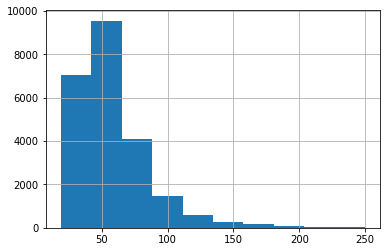

52.0

In [44]:
print(data['total_area'].describe())  # смотрим цифровые характеристики общей площади
data['total_area'].hist()  # смотрим гистограмму
plt.show()
data['total_area'].median()

В общей площади объектов после проведенной обработки выбросов наблюдается разброс от 19 до 250 кв. м. Средняя площадь объектов в базе - около 60кв.м., медианная - 52 кв.м., разница объясняется наличием крупных объектов.

Сократим range до 100:

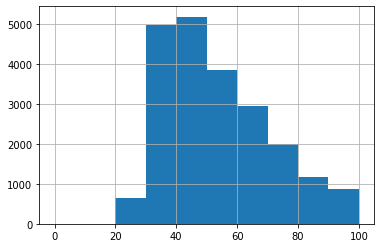

In [45]:
data['total_area'].hist(range = (0, 100)) 
plt.show()

При сокращении range наблюдается пиковое значение от 40 до 50 кв.м. - именно таких квартир в базе больше всего.

count    23355.000000
mean        33.852555
std         18.827242
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        220.000000
Name: living_area, dtype: float64


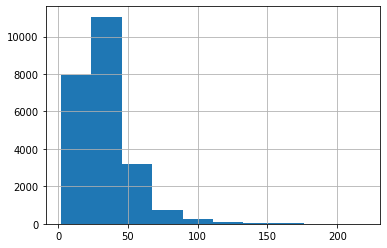

In [46]:
print(data['living_area'].describe())  # смотрим цифровые характеристики жилой площади
data['living_area'].hist()  # смотрим гистограмму
plt.show()

Разброс значений жилой площади от 2 до 264, среднее значение - 34 кв.м. Объекты с маленькой жилой площадью (менее законодательно установленных минимальных 14 м.) являются апартаментами.

count    23355.000000
mean        10.443102
std          5.579782
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64


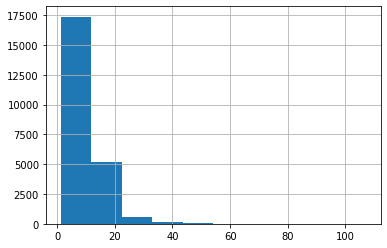

In [47]:
print(data['kitchen_area'].describe())  # смотрим цифровые характеристики площади кухни
data['kitchen_area'].hist()  # смотрим гистограмму
plt.show()

Наблюдается разброс значений от 1.3 кв. м. (апартаменты) до 107 кв. м. Среднее значение 10.4 кв.м.

count    2.335500e+04
mean     6.204108e+06
std      7.079360e+06
min      1.219000e+04
25%      3.420000e+06
50%      4.620000e+06
75%      6.722500e+06
max      3.300000e+08
Name: last_price, dtype: float64


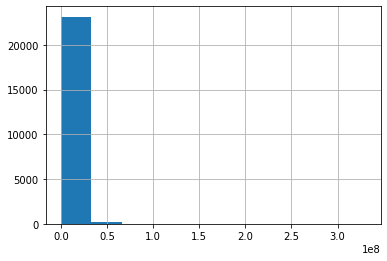

4620000.0

In [48]:
print(data['last_price'].describe())  # смотрим разброс цены
data['last_price'].hist()  # смотрим гистограмму
plt.show()
data['last_price'].median()

Стоимость сильно разнится - от 12 000 рублей за объект до 330 млн. рублей. Подобный разброс объясняется значительными отличиями в площади и инфраструктуре объектов, а также территориальным разбросом (центр Санкт-Петербурга и небольшое село без инфраструктуры, например). Средняя стоимость - 6,4 млн. руб, медианная - 4,6 млн. рублей.

count    23355.000000
mean         2.055149
std          1.028600
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: rooms, dtype: float64


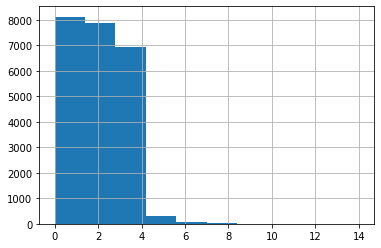

In [49]:
print(data['rooms'].describe())  # смотрим цифровые характеристики кол-ва комнат
data['rooms'].hist()  # смотрим гистограмму
plt.show()

В среднем объекты в базе недвижимости состоят из двух комнат.

count    23355.000000
mean         5.882552
std          4.871830
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


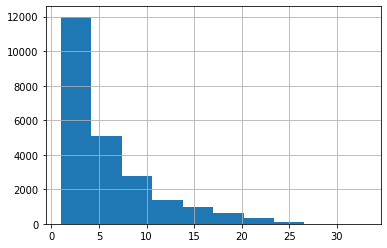

In [50]:
print(data['floor'].describe())  # смотрим цифровую характеристику этажей
data['floor'].hist()  # строим гистограмму
plt.show()

Этажи наблюдаются от 1 до 33, среднее значение 5-6 этаж. По гистограмме наблюдается значительный пик в районе 1-4 этажа, что объясняется значительным историческим (малоэтажным) фондом.

другой       17204
последний     3277
первый        2874
Name: floor_type, dtype: int64


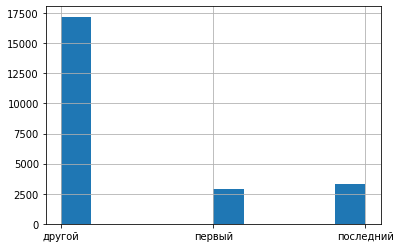

In [51]:
print(data['floor_type'].value_counts())  # смотрим цифровую характеристику этажности
data['floor_type'].hist()
plt.show()

У большей части объектов "другой" этаж, ни первый, ни последний (74%). Первых и последних примерно одинаково, что видно по гистограмме (12% и 14% соответственно)

count    23355.000000
mean        10.692443
std          6.580188
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64


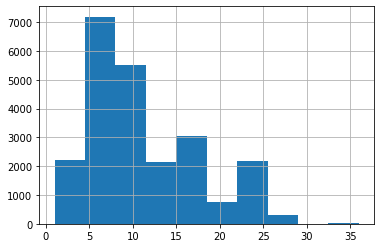

In [52]:
print(data['floors_total'].describe())  # смотрим цифровую характеристику этажности
data['floors_total'].hist()  
plt.show()

Больше всего зданий со средней этажностью - 5-7, что соответствует популярной застройке "спальных районов" 70-80-90 годов. Наблюдаются также отдельные пики 15-18этажных зданий (более новые районы с высотной застройкой, конец 90- 2000-ые годы) и 22-25этажные (2000-ые). 

count    17893.000000
mean     14238.157156
std       8609.536237
min        181.000000
25%       9329.000000
50%      13138.000000
75%      16294.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


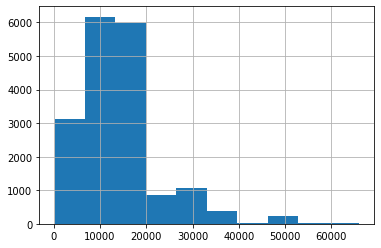

In [53]:
print(data['cityCenters_nearest'].describe())  # смотрим расстояние до центра города
data['cityCenters_nearest'].hist()  
plt.show()

Удаленность от центра наблюдается от 181 метров до 66 км. Больше всего объектов расположено на расстоянии 8-20 км. 

count    17872.000000
mean     28806.882274
std      12653.190370
min          0.000000
25%      18539.000000
50%      26772.000000
75%      37294.000000
max      84869.000000
Name: airports_nearest, dtype: float64


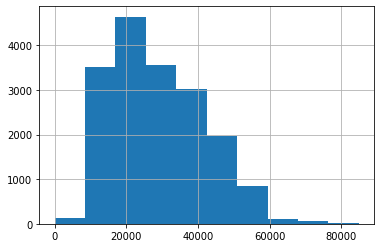

In [54]:
print(data['airports_nearest'].describe())  # смотрим расстояние до ближайшего аэропорта
data['airports_nearest'].hist()  
plt.show()

Явный пик на гистограмме - примерно 20 км от аэропорта. Минимальные значения - 0, апартаменты прямо у аэропорта, максимальное - 84 км.

count    7932.000000
mean      491.516011
std       342.318401
min         1.000000
25%       288.000000
50%       455.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64


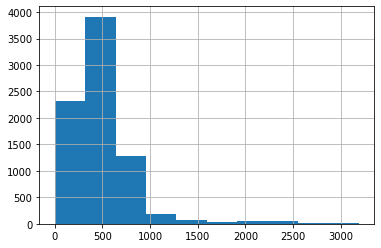

In [55]:
print(data['parks_nearest'].describe())  # смотрим расстояние до ближайшего парка
data['parks_nearest'].hist()
plt.show()

В Санкт-Петербурге и Ленинградской области много парков: в среднем в 500 метрах от объектов недвижимости находится как минимум 1. 

count    23355.000000
mean         6.403511
std          3.493012
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64


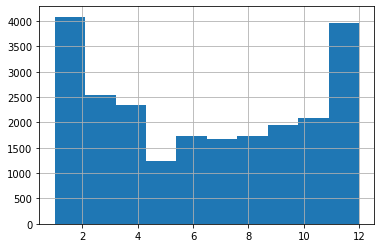

In [56]:
print(data['month'].describe())  # смотрим цифровые характеристики
data['month'].hist()
plt.show()

Больше всего объявлений выставляются в январе и декабре. Меньше всего- в мае.

count    23355.000000
mean         2.566645
std          1.787660
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: day_of_week, dtype: float64


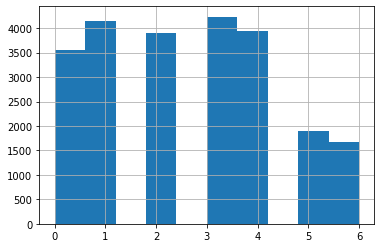

In [57]:
print(data['day_of_week'].describe())
data['day_of_week'].hist()
plt.show()

Логичное распределение по дням недели - чаще всего объявления публикуются в рабочие будни, особенно во вторник, среду и четверг. Меньше всего в субботу и воскресенье.

Проведен анализ объектов в базе после проведенной предобработки. Отмечены следующие пиковые значения: чаще всего выставляются квартиры среднего размера - около 50 кв.м., с 1-2 комнатами, жилой площадью около 35 кв.м. и кухней порядка 10 кв.м. Самые популярные этажи - 2-5 в 5-7-этажных домах. Средняя стоимость составляет 6,4 млн. руб, медианная - 4,6 млн. рублей.
    Чаще всего объявления публикуются зимой - в декабре и январе, реже всего в мае. Большинство объявлений появляется в будни. 

#### 4.2 Анализ скорости продаж квартир 

count    20212.000000
mean       180.474965
std        219.293396
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


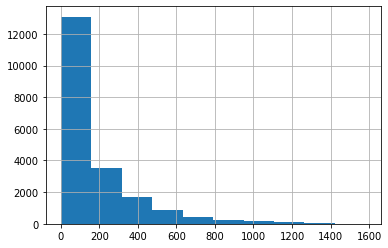

95.0

In [58]:
print(data['days_exposition'].describe())  # смотрим сколько дней было размещено каждое объявление
data['days_exposition'].hist()
plt.show()
data['days_exposition'].median()

Уменьшаем range до 100, аналогично устанавливаем количество корзин:

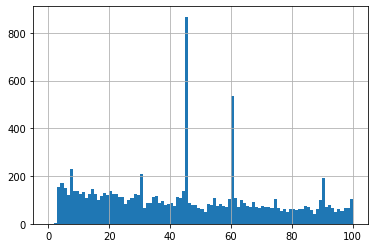

In [59]:
data['days_exposition'].hist(bins = 100, range =(0,100))
plt.show()

Проведен анализ скорости продажи квартир. Судя по гистограмме по всем данным основной пик закрытия сделок происходит в интервале 0-180 дней - то есть примерно 5-6 месяцев. Среднее значение составляет как раз 181 день. При этом медианное значение - 95 дней, т.е. три месяца. Именно этот показатель предлагаем считать "средним", "нормальным" сроком для продажи умеренно ликвидной недвижимости. Значительная разница между средним и медианным показателем обусловлена наличием в базе не только активного рынка недвижимости Санкт-Петербурга, но и менее "живого" рынка Ленинградской области, особенно небольших удаленных населенных пунктов.

Говоря о "быстрых" продажах, то этот показатель можно зафиксировать на уровне первого квартиля (25 процентиль) - 45 дней или полтора месяца. Быстрее продажи производятся только в случае необычайно ликвидного объекта и/или сниженной цены в сравнении с рыночной.

Уменьшение рассматриваемого интервала помогло выделить два явных пика - после 40 дней и в 60 дней. Можно сделать вывод о том, что у ликвидных квартир (уходят в рынка в медианную величину времени - примерно за 3 месяца) находятся покупатели в период около 1,5 месяца - 2 месяца. Это соответствует рассчитанным по 1 квартилю "быстрым" сделкам. 

#### 4.3 Какие факторы больше всего влияют на общую (полную) стоимость объекта?

Рассмотрим зависимость цены от следующих факторов:

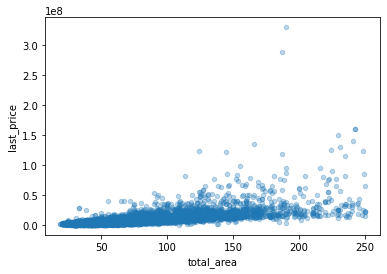

0.6700272964498416

In [61]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3)
plt.show()
data['last_price'].corr(data['total_area'])

Проанализировав взаимосвязь данных с помощью графика scatter можно заключить, что зависимость стоимости и общей площади объекта высока при небольших и средних значениях площади, при этом выбросы отмечаются при любой площади квартир. Чем выше площадь - тем меньше зависимость. 
Коэффициент корреляции Пирсона составляет 0.67 - это говорит о наличии связи, однако не слишком сильной. Выходит, увеличение площади сопровождается ростом цены, но так бывает не всегда.  

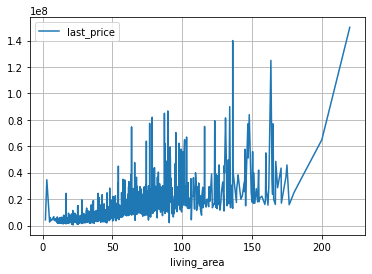

In [62]:
data.pivot_table(index = "living_area", values = 'last_price').plot(grid=True)
plt.show()

В целом распределение похоже на предыдущее, зависимость цены от общей площади, т.к. увеличение жилой площади и общей происходит одновременно. Также наблюдаются единичные выбросы высокой цены, что видимо связано с более высоким уровнем (и сответственно ценой) отдельных объектов. Свыше 200 кв. м. и особенно свыше 250 кв.м. наблюдается уже более неравномерное распределение, что связано с 1) немногочисленностью этих объектов в базе 2)особым ценообразованием квартир со значительной площадью - они уже не столь ликвидны и иногда приходится сильно снижать цену в сравнении с менее большими объектами.

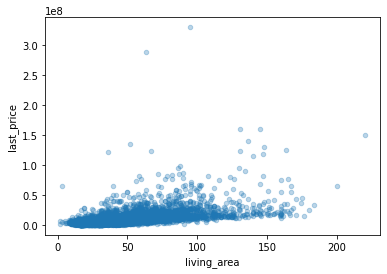

0.5825473251610127

In [63]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.3)
plt.show()
data['last_price'].corr(data['living_area'])

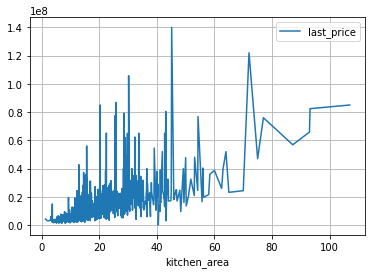

In [64]:
data.pivot_table(index = "kitchen_area", values = 'last_price').plot(grid=True)
plt.show()

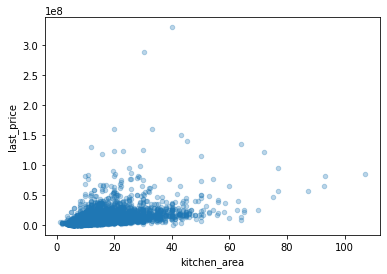

0.5426041717098331

In [65]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3)
plt.show()
data['last_price'].corr(data['kitchen_area'])

Цена растет в зависимости от роста площади кухни (с единичными выбросами), но на уровне 70+ метров происходит падение цены. Объясняется скорее всего опять-таки большой общей площадью квартиры и меньшей ликвидностью столь больших объектов.

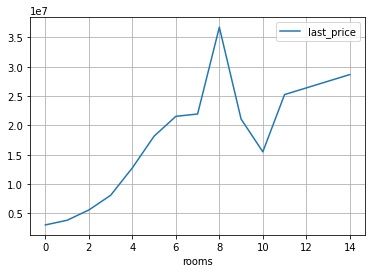

In [66]:
data.pivot_table(index = "rooms", values = 'last_price').plot(grid=True)
plt.show()

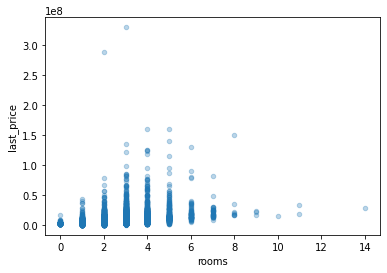

0.39428878968193093

In [67]:
data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.3)
plt.show()
data['last_price'].corr(data['rooms'])

Цена растет пропорционально росту количества комнат до 8 комнат, после чего начинает падать. Это объясняется невысокой востребованностью объектов с 8+ комнатами - современные домохозяйства (люди, проживающие в одном жилом помещении) обычно состоят из одной семьи (поколения), родители + дети, без других родственников, поэтому большее число комнат не востребовано.

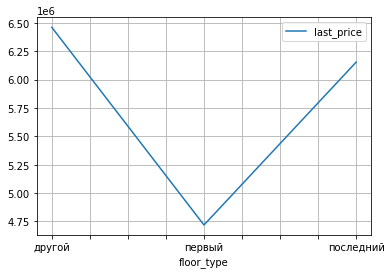

In [68]:
data.pivot_table(index = "floor_type", values = 'last_price').plot(grid=True)
plt.show()

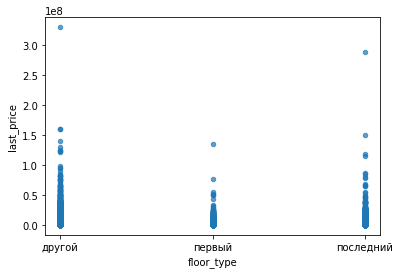

In [69]:
data.plot(x='floor_type', y='last_price', kind='scatter', alpha=0.7)
plt.show()

Меньше всего стоят объекты на первом этаже, что достаточно традиционно для рынка недвижимости. Это объясняется как вопросами безопасности, так и близостью квартиры к коммуникациям/подвальным помещениям, а также большой проходимостью этажа. Разницы в востребованности других этажей, в том числе и последнего, не отмечается. 

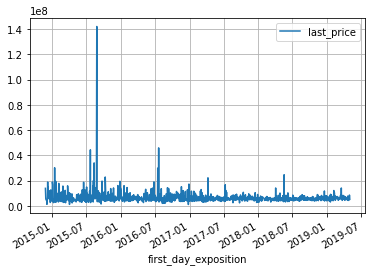

In [70]:
data.pivot_table(index = "first_day_exposition", values = 'last_price').plot(grid=True)
plt.show()

По графику зависимости цены от точной даты выставления объявления можно вспомнить все исторические и экономические события этих годов. Резкий выброс в августе-сентябре 2015 года - экономический кризис, резкий рост евро и доллара - как правило люди предпочитают в такие моменты вкладывать средства в более стабильную недвижимость. 

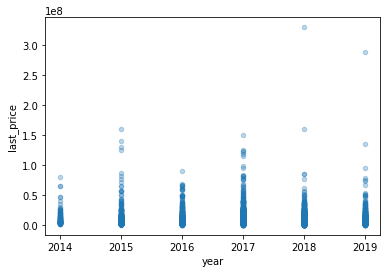

-0.048872827249316075

In [72]:
data.plot(x='year', y='last_price', kind='scatter', alpha=0.3)
plt.show()
data['last_price'].corr(data['year'])

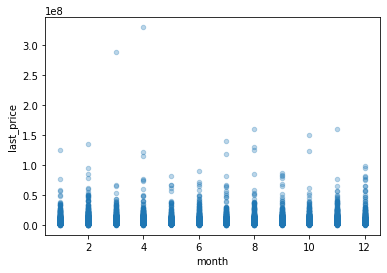

0.005563153482870703

In [73]:
data.plot(x='month', y='last_price', kind='scatter', alpha=0.3)
plt.show()
data['last_price'].corr(data['month'])

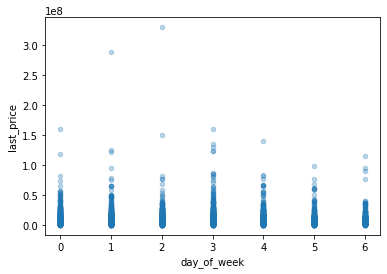

-0.010985171389649885

In [74]:
data.plot(x='day_of_week', y='last_price', kind='scatter', alpha=0.3)
plt.show()
data['last_price'].corr(data['day_of_week'])

Проанализировано влияние различных факторов на цену жилья.
    Между общей площадь объекта и его стоимостью есть связь, однако не слишком сильная (коэффициент корреляции Пирсона - 0.67). Схожая ситуация с жилой площадью, площадью кухни и количеством комнат - связь есть, но все слабее. Например корреляция количества комнат и стоимости - всего 0,39.
    Заметно влияет на стоимость объекта его этаж - первый этаж сильно снижает стоимость квартиры. 
    Зависимость стоимости от года, дня: наблюдается незначительная отрицательная корреляция, месяц - незначительная положительная. В целом влияние на стоимость объекта практически отсутствует. </div>

#### 4.4 Средняя цена одного кв.метра в 10 населённых пунктах с наибольшим числом объявлений

Рассчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 

In [75]:
locality_10_big = data.pivot_table(index='locality_name', values= 'price_sq_m', aggfunc = ["mean", "count"])
locality_10_big.columns = ['mean_price', 'count']
locality_10_big = locality_10_big.sort_values(by='count', ascending = False).head(10)
print(locality_10_big)
print(locality_10_big.sort_values(by='mean_price', ascending = False))


                    mean_price  count
locality_name                        
Санкт-Петербург  114013.701124  15491
Мурино            86027.744747    583
Кудрово           95261.963450    469
Шушары            78519.456324    437
Всеволожск        68813.029476    395
Пушкин           103075.030958    364
Колпино           75333.295801    337
Парголово         90160.823107    326
Гатчина           68746.146763    307
Выборг            58191.166107    234
                    mean_price  count
locality_name                        
Санкт-Петербург  114013.701124  15491
Пушкин           103075.030958    364
Кудрово           95261.963450    469
Парголово         90160.823107    326
Мурино            86027.744747    583
Шушары            78519.456324    437
Колпино           75333.295801    337
Всеволожск        68813.029476    395
Гатчина           68746.146763    307
Выборг            58191.166107    234


 Определено десять населенных объектов с самым большим количеством объявлений - Санкт-Петербург, Мурино,Кудрово,Шушары, Всеволожск, Пушкин, Колпино, Парголово, Гатчина, Выборг. Это крупнейшие населенные пункты Ленинградской области, распределение понятно. 
В представленных топ-10 городов рассчитана стоимость квадратного метра дороже всего в Санкт-Петербурге и Пушкине, дешевле всего в Выборге. 

#### 4.5 Средняя цена каждого километра в Санкт-Петербурге

Изучим распределение стоимости кв.м. в зависимости от удаленности от центра Санкт-Петербурга

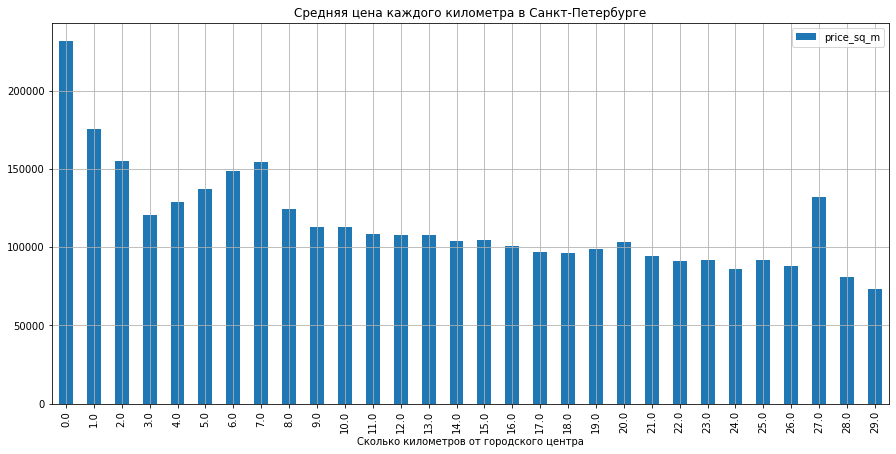

In [76]:
data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values = 'price_sq_m', aggfunc = 'mean')
data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values = 'price_sq_m', aggfunc = 'mean').plot(kind = 'bar', grid = True,figsize=(15,7), xlabel = 'Сколько километров от городского центра', title = 'Средняя цена каждого километра в Санкт-Петербурге')
plt.show()

По мере удаления объектов от городских центров стоимость квадратного метра снижается, хотя не очень равномерно. Отмечается резкий провал стоимости объектов на 3 км. и рост стоимости на 4-7 и последующее равномерное снижение с 8 км до 27, где снова отмечен резкий скачок цены. Т.к. подавляющее большинство (почти 70%) базы составляют объекты из Санкт-Петербурга, то можно попробовать проанилизировать с чем связаны эти скачки.

В радиусе 3 км. от центра находится так называемый "золотой треугольник": объекты недвижимости центрального района Санкт-Петербурга (Невский пр., Садовая улица и др), а также Большой и Малый пр. Васильевского острова и Петроградский район. Эти районы являются самыми престижными и элитными в Санкт-Петербурге, что добавляет повышающий коэффициент к стоимости жилых объектов. Кроме того многие объекты в этом радиусе обладают собственной исторической ценностью. 

За пределами 3 км. начинаются тоже востребованные и дорогие, но уже не столь престижные районы - наб. Обводного Канала, более удаленные территории Васильевского острова, Выборгская сторона. "Провал" стоимости предположительно обусловлен исчезновением повышенной наценки в этих районах, но стоимость квадратного метра остается по-прежнему очень высокой, постепенно снижаясь по мере удаления от центра. 

Рост стоимости квадратного метра на расстоянии 7 км. от центра предположительно связан с расположением объектов в Приморском районе. Это относительно новый спальный район с высотными новостройками, более современными планировками и хорошими коммуникациями. Кроме того именно в Приморском районе находится Лахта-центра, головной офис ПАО Газпром, что заметно сказалось на росте цен в районе.

In [77]:
data.query('(locality_name == "Санкт-Петербург")&(cityCenters_nearest_km==27)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,day_of_week,month,year,floor_type,cityCenters_nearest_km
748,13,14350000,74.0,2017-11-28,2,3.13,5,30.0,3,True,...,1496.0,0,NaN,128.0,193918.918919,1,11,2017,другой,27.0
5961,6,2250000,32.0,2018-02-27,1,2.65,2,16.5,2,True,...,NaN,0,NaN,178.0,70312.500000,1,2,2018,последний,27.0


Резкий рост на 27 км. обусловлен скорее всего именно такой удаленностью от Санкт-Петербурга по северному направлению части Курортного района, территории с дорогой частной недвижимостью и элитными коттеджными поселками, стоимость жилья в которых также выросла после начала строительства Лахта-центра. Кроме того в базе всего 2 объекта с такой удаленностью, что не позволяет говорить о каких-то значимых тенденциях.

Изучено распределение стоимости кв.м. в зависимости от удаленности от центра Санкт-Петербурга: зависимость наблюдается - по мере удаления объектов от городских центров стоимость квадратного метра снижается. Однако наблюдаются выбросы, связанные с популярными и востребованными районами.

### 5. Общий вывод

В результате проведенного исследования была проанализированы данные сервиса Яндекс.Недвижимость за 2015-2019 гг. по Санкт-Петербургу и Ленинградской области. Большинство представленных в базе объектов (2/3 всей базы) относятся к Санкт-Петербургу, остальные к крупным населенным пунктам Ленинградской области (Мурино, Кедрово, Шушары, Всеволожск, Пушкин) и более мелким населенным пунктам. 

При подготовке базы часть отсутствующих данных была заполнена средними, медианными и иными показателями, часть - удалена (менее 2% от общего числа записей), часть - оставлена без изменений. Данные были приведены к соответствующим их значениям типам. Явные редкие и аномальные значения (выбросы) были удалены, однако часть из них (в том числе объекты с очень большой площадью) было признано целесообразным сохранить, т.к. рынок недвижимости России в целом и Санкт-Петербурга и ЛО в частности отличается сильной разнородностью и большим разбросом видов объектов. Слишком сильное "усреднение" данных приведет к искажению картины.

При анализе обработанной базы было выявлено следующее:

1) Средняя цена объектов недвижимости сильно разнится и находится в радиусе от 12 000 рублей за объект до 330 млн. рублей, что соответствует тенденциям всего российского рынка недвижимости. Стоимость квадратного метра дороже всего в Санкт-Петербурге (115 тыс.руб за кв.м) и в г. Пушкине (103 тыс.руб за кв.м).

2) Портрет типичного "усредненного" объекта недвижимости в нашей базе: двухкомнатная квартира с общей площадью около 50 кв.м. и кухней около 10 кв. м., стоимость 4.6-6.2 млн. рублей. Расположена на 2-4 этаже 5-7-этажного дома, в полукилометре от дома есть парк, в 20 км - аэропорт. 

3) Больше всего объявлений выставляются в январе и декабре. Меньше всего- в мае.

4) Влияние на стоимость объекта недвижимости оказывают: общая (и, соответственно, жилая) площадь объекта (коэффициент корреляции 0,67 - связь есть, но не очень сильная); этажность (первый этаж сильно дешевле других); инфраструктура - удаленность от центра (хотя возможны выбросы, в том числе наличие дорогой загородной недвижимости, удаленных, но новых и современных районов и тп).Зависимость стоимости от года и дня: наблюдается незначительная отрицательная корреляция, месяц - незначительная положительная. В целом заметная линейная связь отсутствует.</div>